In [19]:
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.pipeline import Pipeline
from cuml import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from cuml.metrics import accuracy_score
from cuml.neighbors import KNeighborsClassifier
import mlflow
import seaborn as sns
from cuml.preprocessing import FunctionTransformer
import mlflow.sklearn
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [21]:
df_features = pd.read_csv("prepared_data.csv")
df_features = df_features.fillna(0)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_features["clean_msg"], df_features["target"],
                                                     random_state=42, stratify=df_features["target"], test_size=0.2)

In [29]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
if mlflow.search_experiments("spams") == None:
    mlflow.create_experiment("spams")

mlflow.set_experiment("spams")
mlflow.sklearn.autolog(disable=True)

In [30]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, n_layers=1, dropout=0.2, bidirectional=False):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=bidirectional
        )

        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)

        self.dropout = nn.AlphaDropout(dropout)

    def forward(self,X):
        embedded = self.embedding(X)

        lstm_out, (hidden,cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        else:
            hidden = self.dropout(hidden[-1,:,:])

        out = self.fc(hidden)
        return torch.sigmoid(out)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
vocab_size = 1500
X_train, X_test, y_train, y_test = train_test_split(
    df_features["clean_msg"], df_features["target"], random_state=42, stratify=df_features["target"], test_size=0.2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=42, test_size=0.25, stratify=y_train
)

# Convert data to strings (for CountVectorizer) and sample subset
X_train = X_train[:1000].astype(str)
X_val = X_val[:1000].astype(str)
y_train = y_train[:1000]
y_val = y_val[:1000]

# Vectorization
vectorizer = CountVectorizer(max_features=vocab_size, stop_words="english")
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_val_vectorized = vectorizer.transform(X_val).toarray()

# Convert to Tensors and Move to Device
X_train_tensor = torch.tensor(X_train_vectorized, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_vectorized, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# LSTM Model and Training Setup
embedding_dim = 128
hidden_dim = 128
n_layers = 2
dropout = 0.05
bidirectional = True
learning_rate = 0.025
n_epochs = 200

# Initialize Model and Move to Device
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, n_layers, dropout, bidirectional).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_model(model, train_loader, criterion, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            # Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Evaluation Function with Recall Calculation
def evaluate_model(model, val_loader):
    model.eval()
    true_positives = 0
    false_negatives = 0
    false_positives = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            
            # Calculate True Positives, False Positives, and False Negatives
            true_positives += ((predicted == 1) & (labels == 1)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()

    # Calculate Recall for the Positive Class
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    print(f'Recall: {recall:.4f}')
    return recall

# Training and Evaluation
train_model(model, train_loader, criterion, optimizer, n_epochs)
evaluate_model(model, val_loader)


Epoch [1/200], Loss: 0.4541
Epoch [2/200], Loss: 0.5208
Epoch [3/200], Loss: 0.5050
Epoch [4/200], Loss: 0.5006
Epoch [5/200], Loss: 0.4729
Epoch [6/200], Loss: 0.4717
Epoch [7/200], Loss: 0.5283
Epoch [8/200], Loss: 0.4760
Epoch [9/200], Loss: 0.4903
Epoch [10/200], Loss: 0.5055
Epoch [11/200], Loss: 0.4664
Epoch [12/200], Loss: 0.4588
Epoch [13/200], Loss: 0.5131
Epoch [14/200], Loss: 0.4873
Epoch [15/200], Loss: 0.5103
Epoch [16/200], Loss: 0.4839
Epoch [17/200], Loss: 0.4786
Epoch [18/200], Loss: 0.4944
Epoch [19/200], Loss: 0.4690
Epoch [20/200], Loss: 0.4912
Epoch [21/200], Loss: 0.4938
Epoch [22/200], Loss: 0.4781
Epoch [23/200], Loss: 0.4937
Epoch [24/200], Loss: 0.4852
Epoch [25/200], Loss: 0.4690
Epoch [26/200], Loss: 0.5077
Epoch [27/200], Loss: 0.4770
Epoch [28/200], Loss: 0.5072
Epoch [29/200], Loss: 0.5299
Epoch [30/200], Loss: 0.5055
Epoch [31/200], Loss: 0.5713
Epoch [32/200], Loss: 0.4933
Epoch [33/200], Loss: 0.4872
Epoch [34/200], Loss: 0.4912
Epoch [35/200], Loss: 0

KeyboardInterrupt: 

In [10]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("transformer", FunctionTransformer(lambda x: x.astype(str))),
    ("tfidf",TfidfVectorizer()),
    ("lr", LogisticRegression())
])

grid = {
    "tfidf__max_df": [0.8,0.9],
    "tfidf__ngram_range": [(1,1), (2,2)],
    "tfidf__max_features": [1000,3000,5000],
    "lr__penalty": ["l1","l2","elasticnet"],
    "lr__fit_intercept": [True, False],
    "lr__solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    scoring=["recall","precision","f1"],
    refit="f1",
    verbose=2,
    return_train_score=True,
    cv=4
)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total t

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solve

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solve

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solve

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=1000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solve

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=3000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solve

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l1, lr__solver=saga, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__solver=lbfgs, tfidf__max_df=0.8, tfidf__max_features=1000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END lr__fit_intercept=True, lr__penalty=l2, lr__so

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
960 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ibrahim/miniforge3/envs/scienc

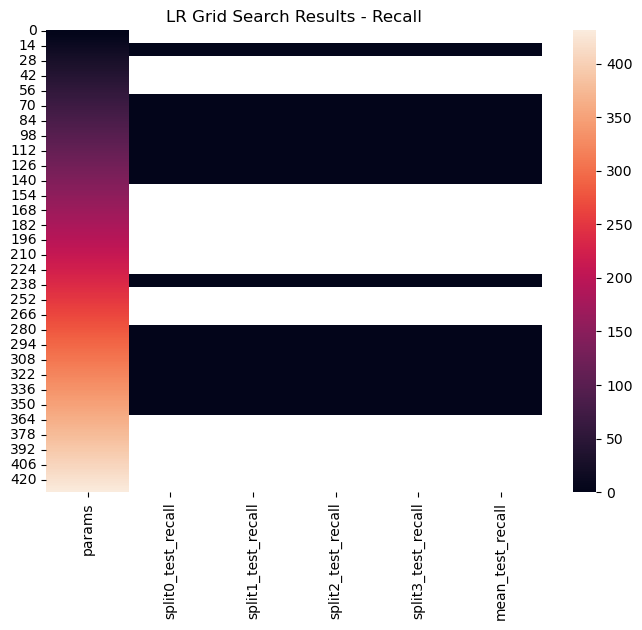

In [11]:
from sklearn.metrics import recall_score, precision_score, f1_score

grid_search.fit(X_train, y_train)

df_results = pd.DataFrame(grid_search.cv_results_)

X_train, X_test, y_train, y_test = train_test_split(
    df_features["clean_msg"],
    df_features["target"],
    test_size=0.2,
    random_state=42,
    stratify=df_features["target"]
)

with mlflow.start_run(run_name="lr_classifier"):
    best_nb = grid_search.best_estimator_
    y_pred = best_nb.predict(X_test)
    class_report = pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

    class_report.to_csv("lr_report.csv")
    mlflow.log_artifact("lr_report.csv", "lr_report.csv")

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results.to_csv("lr_results.csv")

    mlflow.log_artifact("lr_results.csv", "lr_results.csv")

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("type","Logistic Regression")
    
    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_lr_model")

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    mlflow.log_metrics({"Best F1 Score": f1, "Best Recall Score": recall, "Best Precision Score": precision})

    for i in range(0,len(df_results["params"])):
        mlflow.log_metrics({
                            "lr_test_recall": df_results.at[i,"mean_test_recall"],
                            "lr_test_precision": df_results.at[i,"mean_test_precision"],
                            "lr_test_f1": df_results.at[i,"mean_test_f1"],
                            "lr_train_recall": df_results.at[i,"mean_train_recall"],
                            "lr_train_precision": df_results.at[i,"mean_train_precision"],
                            "lr_train_f1": df_results.at[i,"mean_train_f1"]
            }, step=i)
        
    mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
    
    pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=False)
    plt.title("LR Grid Search Results - Recall")
    plt.savefig("grid_lr_heatmap.png")
    mlflow.log_artifact(local_path="grid_lr_heatmap.png", artifact_path="grid_lr_heatmap.png")


In [12]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ("transformer", FunctionTransformer(lambda x: x.astype(str))),
    ("tfidf", TfidfVectorizer()),
    ("rf", RandomForestClassifier())
])

grid = {
    "tfidf__ngram_range": [(1,1), (2,2)],
    "rf__n_estimators": [50, 100,150],
    "rf__criterion": ["gini", "entropy", "log_loss"],
    "rf__max_depth": [5,10,15,20]    
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    verbose=1,
    scoring=["recall","precision","f1"],
    refit="f1",
    return_train_score=True,
    cv=4
)

grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('transformer',
                                        FunctionTransformer(func=<function <lambda> at 0x70c6a1f83420>)),
                                       ('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': [5, 10, 15, 20],
                         'rf__n_estimators': [50, 100, 150],
                         'tfidf__ngram_range': [(1, 1), (2, 2)]},
             refit='f1', return_train_score=True,
             scoring=['recall', 'precision', 'f1'], verbose=1)

2024/10/31 13:18:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/tmp/ipykernel_62799/3945466642.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index


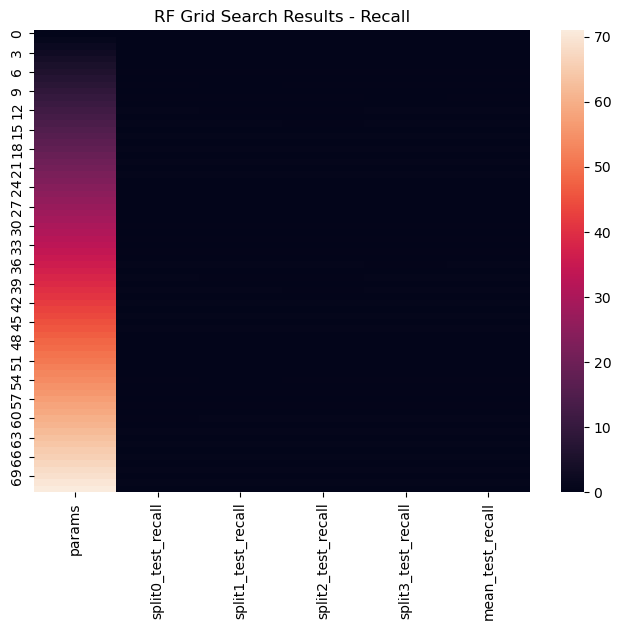

In [13]:
from sklearn.metrics import recall_score, precision_score, f1_score

with mlflow.start_run(run_name="rf_classifier"):
    best_nb = grid_search.best_estimator_
    y_pred = best_nb.predict(X_test)
    class_report = pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

    class_report.to_csv("rf_report.csv")
    mlflow.log_artifact("rf_report.csv", "rf_report.csv")

    mlflow.log_params(grid_search.best_params_)

    mlflow.log_param("type","Random Forest")

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results.to_csv("rf_results.csv")

    mlflow.log_artifact("rf_results.csv", "rf_results.csv")
    
    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_rf_model")

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    mlflow.log_metrics({"Best F1 Score": f1, "Best Recall Score": recall, "Best Precision Score": precision})

    for i in range(0,len(df_results["params"])):
        mlflow.log_metrics({
                            "rf_test_recall": df_results.at[i,"mean_test_recall"],
                            "rf_test_precision": df_results.at[i,"mean_test_precision"],
                            "rf_test_f1": df_results.at[i,"mean_test_f1"],
                            "rf_train_recall": df_results.at[i,"mean_train_recall"],
                            "rf_train_precision": df_results.at[i,"mean_train_precision"],
                            "rf_train_f1": df_results.at[i,"mean_train_f1"]
            }, step=i)
        
    mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
    
    pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=False)
    plt.title("RF Grid Search Results - Recall")
    plt.savefig("grid_rf_heatmap.png")
    mlflow.log_artifact(local_path="grid_rf_heatmap.png", artifact_path="grid_rf_heatmap.png")

In [14]:
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(
    df_features["clean_msg"],
    df_features["target"],
    test_size=0.2,
    random_state=42,
    stratify=df_features["target"]
)

pipe = Pipeline([
    ("transformer", FunctionTransformer(lambda x: x.astype(str))),
    ("tfidf", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

grid = {
    "tfidf__max_features": [1000, 3000, 5000],
    "nb__alpha": [i/2 for i in range(1,40)],
    "nb__fit_prior": [True, False]
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    scoring=["recall", "precision", "f1"],
    refit="recall",
    cv=4,
    verbose=2,return_train_score=True
)

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 234 candidates, totalling 936 fits
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=0.5, nb__fit_prior=True, tfi

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=True, tfidf__max_features=1000; total time=   0.0s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

[CV] END nb__alpha=18.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=18.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

[CV] END nb__alpha=19.0, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.2s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.0, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

[CV] END nb__alpha=19.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=True, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=1000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=3000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s
[CV] END nb__alpha=19.5, nb__fit_prior=False, tfidf__max_features=5000; total time=   0.0s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('transformer',
                                        FunctionTransformer(func=<function <lambda> at 0x70c6a1cdede0>)),
                                       ('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0,
                                       4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0,
                                       8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5,
                                       12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, ...],
                         'nb__fit_prior': [True, False],
                         'tfidf__max_features': [1000, 3000, 5000]},
             refit='recall', return_train_score=True,
             scoring=['recall', 'precision', 'f1'], verbose=2)

2024/10/31 13:19:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/tmp/ipykernel_62799/913887312.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index


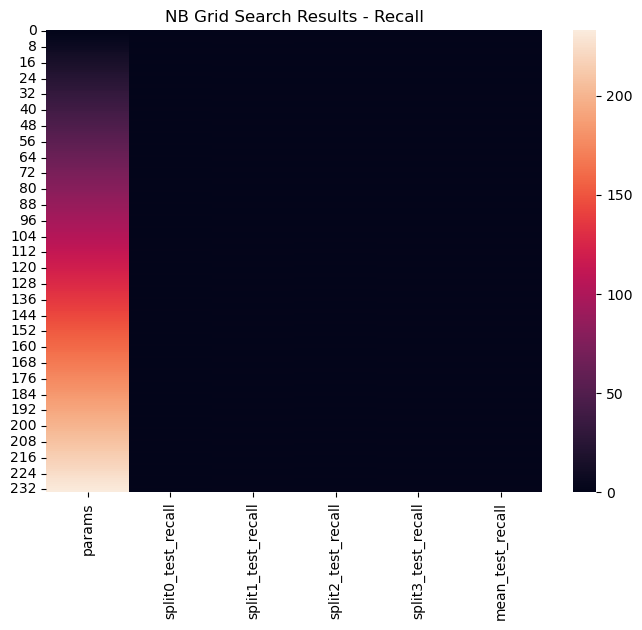

In [15]:
from sklearn.metrics import recall_score, precision_score, f1_score

df_results = pd.DataFrame(grid_search.cv_results_)

with mlflow.start_run(run_name="nb_classifier"):
    best_nb = grid_search.best_estimator_
    y_pred = best_nb.predict(X_test)
    class_report = pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

    class_report.to_csv("nb_report.csv")
    mlflow.log_artifact("nb_report.csv", "nb_report.csv")

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results.to_csv("nb_results.csv")

    mlflow.log_artifact("nb_results.csv", "nb_results.csv")
    
    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_nb_model")

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("type","Naive Bayes")

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    mlflow.log_metrics({"Best F1 Score": f1, "Best Recall Score": recall, "Best Precision Score": precision})

    for i in range(0,len(df_results["params"])):
        mlflow.log_metrics({
                            "nb_test_recall": df_results.at[i,"mean_test_recall"],
                            "nb_test_precision": df_results.at[i,"mean_test_precision"],
                            "nb_test_f1": df_results.at[i,"mean_test_f1"],
                            "nb_train_recall": df_results.at[i,"mean_train_recall"],
                            "nb_train_precision": df_results.at[i,"mean_train_precision"],
                            "nb_train_f1": df_results.at[i,"mean_train_f1"]
            }, step=i)
        
    mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
    
    pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=False)
    plt.title("NB Grid Search Results - Recall")
    plt.savefig("grid_nb_heatmap.png")
    mlflow.log_artifact(local_path="grid_nb_heatmap.png", artifact_path="grid_nb_heatmap.png")


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features[["char_count","digit_count","exclamation_count","dollar_count","sentiment"]],
    df_features["target"],
    test_size=0.2,
    random_state=42,
    stratify=df_features["target"]
)

In [17]:
class SVClassifier():
    def __init__(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            df_features["clean_msg"],
            df_features["target"],
            random_state=42,
            test_size=0.2,
            stratify=df_features["target"]
        )

        self.pipe = Pipeline([
            ("to_str", FunctionTransformer(lambda x: x.astype(str))),
            ("tfidf", TfidfVectorizer()),
            ("svc", SVC())
        ])

        self.grid = {
            "tfidf__max_df": [0.8,0.9],
            "tfidf__ngram_range": [(1,1), (1,2), (2,2), (2,3)],
            "svc__C": [0.1,1,10],
            "svc__kernel": ["linear","rbf"],
            "svc__gamma": ["scale", "auto"]
        }

        self.grid_search = GridSearchCV(
            estimator=self.pipe,
            param_grid=self.grid,
            scoring=["recall","precision","f1"],
            verbose=2,
            refit="recall",
            return_train_score=True,
            cv=4
        )

    def tuning(self):
        self.grid_search.fit(self.X_train, self.y_train)

    def train(self):
        with mlflow.start_run(run_name="svc_model_tuning"):
            mlflow.set_tag("model_name","svc")

            self.tuning()

            mlflow.log_param("Best Parameters",self.grid_search.best_params_)
            mlflow.log_metric("Best Recall Score", self.grid_search.best_score_)

            df_results = pd.DataFrame(self.grid_search.cv_results_)
            df_results.to_csv("svc_results.csv")
            mlflow.log_artifact(local_path="svc_results.csv", artifact_path="svc_results.csv")

            mlflow.log_params(grid_search.best_params_)
            mlflow.log_param("type","SVC")

            for i in range(0, len(df_results["params"])):
                mlflow.log_metrics({"svc_test_recall": df_results.at[i,"mean_test_recall"],
                                    "svc_test_precision": df_results.at[i,"mean_test_precision"],
                                    "svc_test_f1": df_results.at[i,"mean_test_f1"],
                                    "svc_train_recall": df_results.at[i,"mean_train_recall"],
                                    "svc_train_precision": df_results.at[i,"mean_train_precision"],
                                    "svc_train_f1": df_results.at[i,"mean_train_f1"]}, step=i)

            mlflow.log_metrics({"Best Precision Score": df_results["mean_test_precision"].max(),
                               "Best F1 Score": df_results["mean_test_f1"].max()})

            mlflow.log_metrics({"mean_test_recall": df_results["mean_test_recall"].mean(),
                                "mean_test_precision": df_results["mean_test_precision"].mean(),
                                "mean_test_f1": df_results["mean_test_f1"].mean(),
                                "mean_train_recall": df_results["mean_train_recall"].mean(),
                                "mean_train_precision": df_results["mean_train_precision"].mean(),
                                "mean_train_f1": df_results["mean_train_f1"].mean()})
                
            y_pred = self.grid_search.best_estimator_.predict(self.X_test)
                
            report = classification_report(self.y_test, y_pred, output_dict=True)
            report = pd.DataFrame(report).transpose().to_csv("svc_classification_report.csv")
            mlflow.log_artifact("svc_classification_report.csv")

            pivot_table = df_results[['params','split0_test_recall', 'split1_test_recall',
                'split2_test_recall', 'split3_test_recall', 'mean_test_recall']]
            pivot_table["params"] = pivot_table.index
            plt.figure(figsize=(8, 6))
            sns.heatmap(data=pivot_table, annot=True)
            plt.title("SVC Grid Search Results - Recall")
            plt.savefig("grid_svc_heatmap.png")
            mlflow.log_artifact(local_path="grid_svc_heatmap.png", artifact_path="grid_svc_heatmap.png")

            mlflow.sklearn.log_model(self.grid_search.best_estimator_, artifact_path="best_svc_model")

Fitting 4 folds for each of 96 candidates, totalling 384 fits
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=linear, tfidf__max_

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.7s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.8s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.8s
[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.8s
[CV] END svc__C=0.1, svc__gamma=

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.6s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=scale, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.7s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=0.

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.4s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=0.1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=1, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=1, svc__ga

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.2s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=1, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.2s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=10, svc__gamma=scale, svc__kernel=linear, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s
[CV] END svc__C=10, s

/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.4s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.8, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 1); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.4s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(1, 2); total time=   0.4s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 2); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ibrahim/miniforge3/envs/science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[CV] END svc__C=10, svc__gamma=auto, svc__kernel=rbf, tfidf__max_df=0.9, tfidf__ngram_range=(2, 3); total time=   0.3s


/tmp/ipykernel_62799/3414404569.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index
2024/10/31 13:24:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


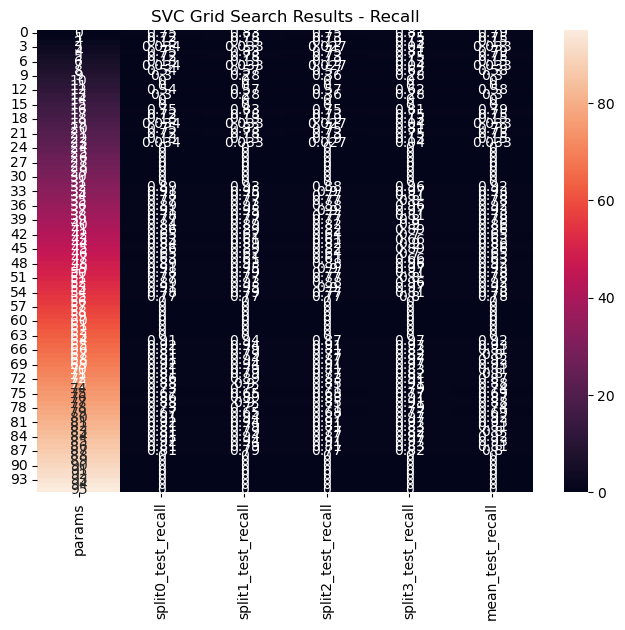

In [18]:
svc = SVClassifier()
svc.train()

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=2, weights=uniform; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END .........algorithm=auto, n_jobs=2, weights=distance; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, weights=uniform; total time=   0.0s
[CV] END ..........algorithm=auto, n_jobs=4, wei

/tmp/ipykernel_62799/2311709714.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_table["params"] = pivot_table.index
2024/10/31 13:25:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


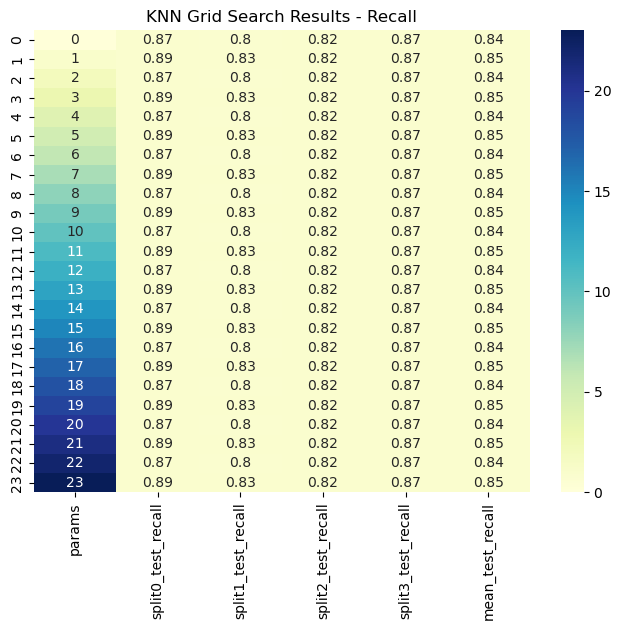

In [19]:
grid = {
    # "n_neighbors": range(3,16,2),
    "weights": ["uniform", "distance"],
    "algorithm": ["auto","ball_tree","kd_tree","brute"],
    "n_jobs": range(2,8,2)
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=grid,
    scoring=["recall","precision","f1"],
    verbose=2,
    refit="recall",
    return_train_score=True,
    cv=4
)


with mlflow.start_run(run_name="knn_model_tuning") as run:
    mlflow.set_tag("model_name", "knn")

    grid_search.fit(X_train, y_train)

    mlflow.log_param('KNN Best Parameters', grid_search.best_params_)
    mlflow.log_metric('Best Recall Score', grid_search.best_score_)

    mlflow.log_metrics({"Best Precision Score": df_results["mean_test_precision"].max(),
                               "Best F1 Score": df_results["mean_test_f1"].max()})

    mlflow.log_params(grid_search.best_params_)
    mlflow.log_param("type","KNN")

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df.to_csv("knn_results.csv")

    mlflow.log_metrics({"mean_test_recall": results_df["mean_test_recall"].mean(),
                        "mean_test_precision": results_df["mean_test_precision"].mean(),
                        "mean_test_f1": results_df["mean_test_f1"].mean(),
                        "mean_train_recall": results_df["mean_train_recall"].mean(),
                        "mean_train_precision": results_df["mean_train_precision"].mean(),
                        "mean_train_f1": results_df["mean_train_f1"].mean()})
    
    for i in range(0, len(df_results["params"])):
                mlflow.log_metrics({"knn_test_recall": df_results.at[i,"mean_test_recall"],
                                    "knn_test_precision": df_results.at[i,"mean_test_precision"],
                                    "knn_test_f1": df_results.at[i,"mean_test_f1"],
                                    "knn_train_recall": df_results.at[i,"mean_train_recall"],
                                    "knn_train_precision": df_results.at[i,"mean_train_precision"],
                                    "knn_train_f1": df_results.at[i,"mean_train_f1"]}, step=i)

    y_pred = grid_search.best_estimator_.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_csv = "classification_report.csv"
    report_df.to_csv(report_csv)
    mlflow.log_artifact(report_csv)

    pivot_table = results_df[['params','split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall',
       'mean_test_recall']]
    pivot_table["params"] = pivot_table.index
    plt.figure(figsize=(8, 6))
    sns.heatmap(data=pivot_table, annot=True, cmap="YlGnBu")
    plt.title("KNN Grid Search Results - Recall")
    plt.savefig("KNN_grid_search_heatmap.png")
    mlflow.log_artifact(local_path="KNN_grid_search_heatmap.png", artifact_path="KNN_grid_search_heatmap.png")

    mlflow.sklearn.log_model(grid_search.best_estimator_, artifact_path="best_knn_model")